# Accumulator

In this notebook, we study the statistics of the accumulator. Specifically, we are interested in the signal-to-noise ratio of of a synapse receiving spikes from an accumulator.

Previously, we've considered the statistics of a synapse with input spikes derived from various processes including Poisson periodic, p-thinned period, and gamma processes. Those analysis hinged on assuming the statistics of the input spike train being fed to the synapse. Here, we don't have the luxury of assuming a particular process (that I know of) to generate spikes for the synapse. Therefore we must first examine the spiking statistics of the accumulator before the statistics of a synapse receiving spikes from the accumulator. The gamma-process spikes, which can be constructed from a Poisson process by only considering every kth spike, is the closest approximation we have to the accumulator spikes. However, the actual accumulator operates under very different conditions:
* Neurons spiking is closer to regular than to Poisson (in NEF networks)
* The accumulator sums spikes from many neurons with each neuron having its own weight

The accumulator is parameterized by a threshold $k$. Below threshold, the accumulator behaves exactly like an integrator. Specifically,

$$
\dot{x} = u
$$

where $x$ is the accumulator state and $u$ is the accumulator input. When the accumulator reaches $k$ ($-k$), it outputs a positive (negative) spike.

The accumulator input can be expressed as

$$u=\sum_{i=1}^N\sum_{j=1}^{K(i)} d_i\delta(t-t_{i,j})$$

where
* $N$ is the number of input neurons
* $K(i)$ is the number spikes emmited by the $i$th neuron
* d_i is the decode weight of the $i$th neuron
* $t_{i,j}$ is the time of the $i$th neuron's $j$th spike

With the above, we can then write the within threshold accumulator state as

$$
x = \sum_i\sum_j d_iH(t-t_{i,j})
$$

where $H(\cdot)$ is the Heaviside step function.

What will the distribution of threshold crossings be?

# Accumulator structure and operation

The accumulator is 15 bits wide and uses the <a href="https://en.wikipedia.org/wiki/Ones%27_complement">one's complement</a> number representation. Each entry in the weight memory is 8 bits wide and also uses the one's complement number representation. In one's complement, the highest order bit indicates the sign while the lower order bits indicate the value. To convert between positive and negative numbers, flip all of the bits in the number. A 3-bit example is given as follows:

<table class="table-bordered">
<tr>
    <th colspan=9>3-bit one's complement example</th>
</tr>
<tr>
    <th>value</th> <th colspan=3>bit position</th> <th></th> <th>value</th> <th colspan=3>bit position</th>
</tr>
<tr>
    <th></th> <th>2</th> <th>1</th> <th>0</th> <th></th> <th></th> <th>2</th> <th>1</th> <th>0</th>
</tr>
<tr>
    <th>0</th> <td>0</td> <td>0</td> <td>0</td> <td></td> <th>-0</th> <td>1</td> <td>1</td> <td>1</td> 
</tr>
<tr>
    <th>1</th> <td>0</td> <td>0</td> <td>1</td> <td></td> <th>-1</th> <td>1</td> <td>1</td> <td>0</td> 
</tr>
<tr>
    <th>2</th> <td>0</td> <td>1</td> <td>0</td> <td></td> <th>-2</th> <td>1</td> <td>0</td> <td>1</td> 
</tr>
<tr>
    <th>3</th> <td>0</td> <td>1</td> <td>1</td> <td></td> <th>-3</th> <td>1</td> <td>0</td> <td>0</td> 
</tr>
</table>

For the given bit widths and the one's complement number system, the accumulator and each weight represent integers in the range [-16384:16384] and [-127:127], respectively.

When a neuron emits a spike, we lookup
* the neuron's decode weight from the weight memory
* the current decoded value from the accumulator memory
* the 3 threshold bits from the accumulator memory

We load the current decoded value into the accumulator and add the weight's value to the current decoded value. Since the weight has fewer bits than the current decoded value, we perform a sign extension to the weight before adding the two. Sign extension means adding extra higher order bits with the same value as the current highest order bit, which indicates the sign. Consider the following examples showing addition of 4 and 3 bit numbers.

<pre><code>
Example: 0+1=1

  0 0 0 0      0 in 4 bits
+   0 0 1    + 1 in 3 bits
---------    ---
  0 0 0 0      0
+ 0 0 0 1    + 1 now sign extended to 4 bits
---------    ---
  0 0 0 1      1 as we expect

Note how we padded the 3 bit number with a 0 because its sign bit was 0.
</code></pre>

<pre><code>
Example: 0-1=-1

  0 0 0 0       0  in 4 bits
+   1 1 0    +(-1) in 3 bits
---------    -----
  0 0 0 0       0
+ 1 1 1 0    +(-1) now sign extended to 4 bits
---------    -----
  1 1 1 0      -1  as we expect

Note how we padded the 3 bit number with a 1 because its sign bit was 1.
</code></pre>

<pre><code>
Example: -1+1=-0

  1 1 1 0     -1 in 4 bits
+   0 0 1    + 1 in 3 bits
---------    ---
  1 1 1 0     -1 
+ 0 0 0 1    + 1 now sign extended to 4 bits
---------    ---
  1 1 1 1     -0 as we expect

The negative sign on the 0 maybe disconcerting, but it will be fine in the one's complement system.
Consider the next example.
</code></pre>

<pre><code>
Example: -0+1=1

  1 1 1 1     -0 in 4 bits
+   0 0 1    + 1 in 3 bits
---------    ---
  1 1 1 1     -0 
+ 0 0 0 1    + 1 now sign extended to 4 bits
---------    ---
  0 0 0 0      0 Perform the addition. It generates a carry out of the highest order bit.
+       1    + 1 In one's complement, we add the generated carry bit to the lowest order bit.
---------    --- 
  0 0 0 1      1 as we expect
</code></pre>


After adding the current decoded value and the weight, we consider the 3 threshold bits. The threshold bits indicate which of the 8 bit positions in the accumulator (shown below) are used for thresholding. When the addition of the weight and the current decoded value causes a transition in the threshold bit (i.e. the decoded value passes the threshold in either the positive or negative direction), an output spike is emitted and the decoded value is shifted back towards 0 by the value of the threshold. Whether a 0->1 or 1->0 transition trips the threshold depends on the sign of the weight being added. For a negative weight, we look for a 1->0 transition, and for a positive weight, we look for a 0->1 transition.

As shown in the following table, bits within positions 6-13 can be used as a threshold bit. Note that the threshold bits overlap with the bitwidth of the weight value, so we may configure a threshold and weight such that each spike in generates a spike out.

<table class="table table-bordered">
    <tr>
        <th colspan=15 style="text-align:center">
            accumulator bit position
        </th>
    </tr>
    <tr class="testrow">
        <td>14</td> <td>13</td> <td>12</td> <td>11</td> <td>10</td>
        <td>9</td> <td>8</td> <td>7</td> <td>6</td> <td>5</td>
        <td>4</td> <td>3</td> <td>2</td> <td>1</td> <td>0</td>
    </tr>
    <tr>
        <td colspan=8></td><th colspan=7 style="text-align:center">weight value</th>
    </tr>
    <tr>
        <td></td><th colspan=8 style="text-align:center">threshold bits</th><td colspan=6></td>
    </tr>
</table>

Note that we must ensure that the weight magnitude $\le$ threshold magnitude. Weight magnitudes greater than the threshold are only possible when the threshold is set to bit position 6, which corresponds to a value of 64. If we allow weights greater than the threshold, we would produce trapped bits that could cause the accumulator to operate incorrectly. To illustrate this, consider the following example with the accumulator adding weights $>$ threshold.

<pre><code>
Threshold position = 6
Threshold value    = 64 = 000 0000 0100 0000
weight             = 65 =          0100 0001

    0 initial decoded value
+  65 add weight
-----
   65 crosses positive threshold
-  64 subtract threshold
-----
    1
+  65 add weight
-----
   66 crosses positive threshold
-  64 subtract threshold
-----
    2 note how remainder increments after threshold subtraction with each spike
  ... after 61 more spikes
-----
   63
+  65 add weight
-----
  128 = 000 0000 1000 0000
        accumulator will not detect change in threshold bit and will miss a spike
        bit will be stranded above the threshold
        If enough stranded bits are accumulated, we could flip the sign of the decoded value.
</code></pre>

Because we prohibit weights greater than the threshold and because of its design, the accumulator **does not and cannot** output more than 1 spike at a time. Given the maximum weight constraint, it is helpful to think of the weights in units of threshold. Increasing the threshold value reduces the maximum weight value and the minimum weight unit, which would make our weight representation more precision. That is, we can trade off dynamic range for precision. The following table tabulates the possible threshold positions and their associated maximum weights, and precision. 

<table class="table table-bordered">
    <tr>
        <th colspan=2>Threshold</th> <td colspan=3> </td>
    </tr>
    <tr>
        <th>Position</th> <th>Value</th> <th>Max Weight</th> <th>Max Weight/Threshold</th> <th>1/Threshold (precision)</th>
    </tr>
    <tr>
        <td>6</td> <td>64</td> <td>64</td> <td>1</td> <td>1/64</td> 
    </tr>
    <tr>
        <td>7</td> <td>128</td> <td>127</td> <td>127/128</td> <td>1/128</td> 
    </tr>
    <tr>
        <td>8</td> <td>256</td> <td>127</td> <td>127/256</td> <td>1/256</td> 
    </tr>
    <tr>
        <td>9</td> <td>512</td> <td>127</td> <td>127/512</td> <td>1/512</td> 
    </tr>
    <tr>
        <td>10</td> <td>1024</td> <td>127</td> <td>127/1024</td> <td>1/1024</td> 
    </tr>
    <tr>
        <td>11</td> <td>2048</td> <td>127</td> <td>127/2048</td> <td>1/2048</td> 
    </tr>    
    <tr>
        <td>12</td> <td>4096</td> <td>127</td> <td>127/4096</td> <td>1/4096</td> 
    </tr>
    <tr>
        <td>13</td> <td>8192</td> <td>127</td> <td>127/8192</td> <td>1/8192</td> 
    </tr>
</table>



# Setting a Threshold and Computing Decode Weights

The chip does not communicate in terms of real numbers but rather spikes, so we map a $x$ to a spike rate $f$. Users typically build their networks so that $x$ operates within the range $[-1:1]$. Spikes are signed, so we can represent "negative" rates. A simple linear mapping converts $x$ to $f$

$$
f=f_{max}x
$$

where $f_{max}$ is the maximum firing rate since $x$ operates from -1 to 1. While simple, this does tie our signal-to-noise ratio to our position in the space of $x$...

Each spike in to the accumulator will be weighted and added to a running sum (i.e. the decoded value). Assuming that the accumulator is always driven towards the positive threshold, the value accumulated over a certain period of time will be given by

$$
\frac{\textrm{spikes_in}}{\textrm{s}}\cdot\frac{\textrm{weight}}{\textrm{spike_in}}\cdot \textrm{time} = \textrm{value accumulated}
$$

We can then apply the threshold to find the number of threshold crossings, or output spikes.

$$
\frac{\textrm{value accumulated}}{\textrm{threshold}}=\textrm{# threshold crossings}=\textrm{spikes out}
$$

To find the output rate, we divide the number of spikes out by the time

$$
\frac{\textrm{spikes out}}{\textrm{time}}=\frac{\textrm{spikes_in}}{\textrm{s}}\cdot\frac{\textrm{weight}}{\textrm{spike_in}}\cdot\frac{1}{\textrm{threshold}}
$$

for $N$ neurons spiking at rates $a_n$ with weights $d_n$ and accumulator with threshold $k$, we can rewrite the previous discussion in the following equation

\begin{align*}
\frac{\sum_{n=1}^Na_nd_n}{k} &= f_{out} \\
\sum_{n=1}^Na_nd_n &= f_{out}k
\end{align*}

That is, we should scale our decode weights by the accumulator threshold to generate the desired output firing rate.

# Simulations

First we run simulations without the weight and threshold constraints on the accumulator (i.e. we can use any integer weight and threshold). We show that it is possible to get a few different output spiking distributions. Next we impose the weight and threshold constraints and use actual NEF networks built by nengo to constrain our simulations.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from datatypes import SpikeTrain, set_list_var
from exp import (
    run_experiment, 
    run_regular_neuron_experiment, run_poisson_neuron_experiment,
    plot_timeseries, plot_isi
)

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import nengo
from nengo.utils.ensemble import tuning_curves

## Single Regular Spiking Neuron

Let's test the accumulator with a single, regular spiking neuron.

### Threshold = Multiple of Weight
First we consider when the threshold is a multiple of the neuron's weight.

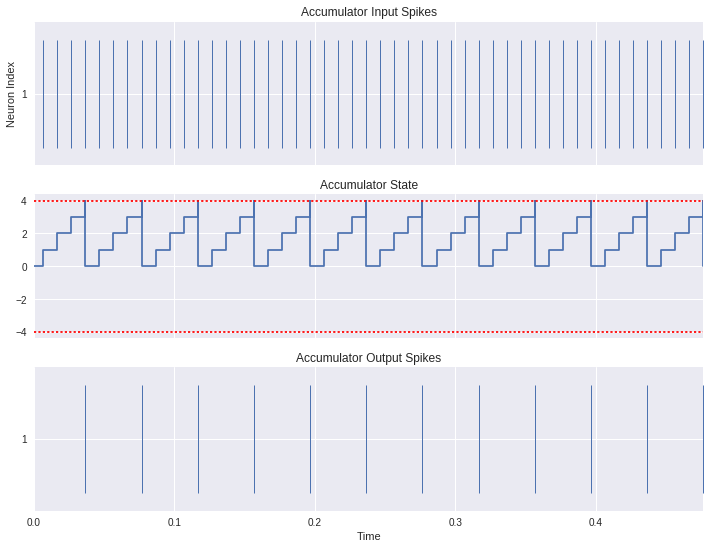

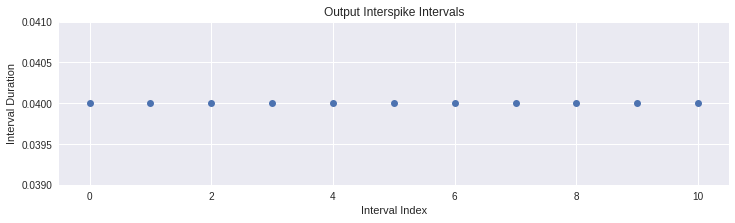

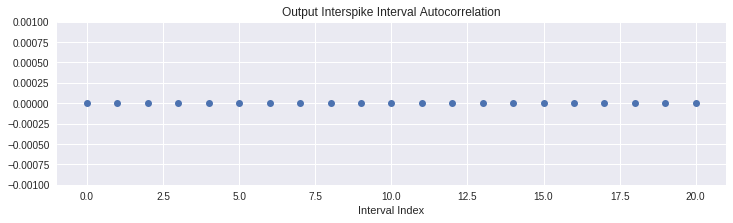

In [24]:
run_regular_neuron_experiment(weight=1, threshold=4)

The top plot shows the neuron's spikes that are fed as input to the accumulator. The middle plot shows the accumulator state in response to the neuron's spikes. Each input spike produces a jump of 1 unit in the accumulator state because the weight is 1. When the accumulator reaches its threshold of 10, shown as a dotted red line, it emits an output spike. The bottom two plots show the accumulator output spikes and their interspike intervals.

Unsurprisingly, all of the output inter-spike intervals are the same. The accumulator simply decimates the traffic by the  weight/threshold ratio. A synapse receiving input from this accumulator would have the same statistics as one receiving input from a regularly spiking neuron operating at the accumulator's output rate.

### Threshold $\neq$ Multiple of Weight

Next, we consider the case when the threshold is not a multiple of the neuron's weight.

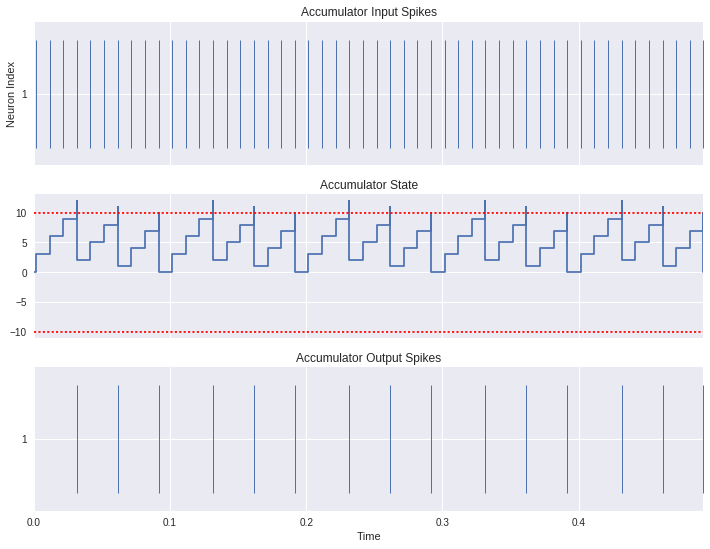

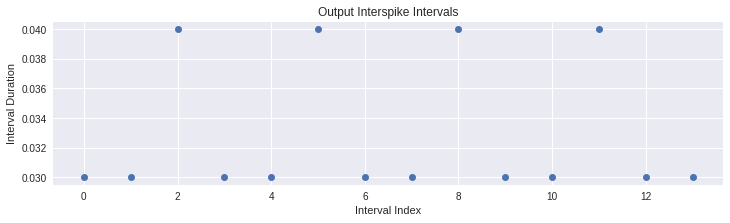

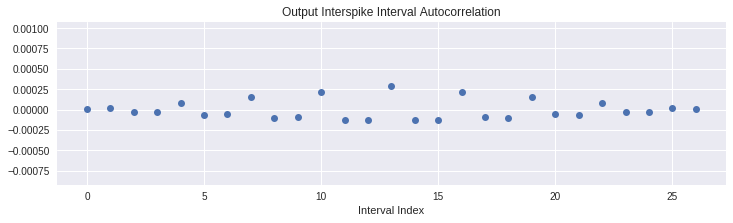

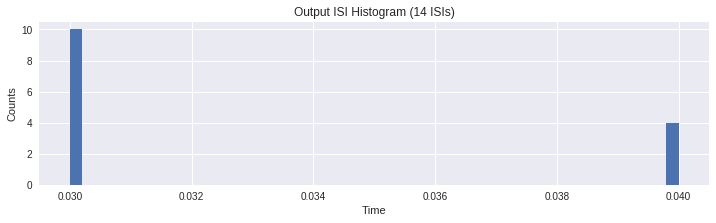

In [25]:
run_regular_neuron_experiment(weight=3, threshold=10)

As the bottom ISI plot and ISI histogram shows, the output spikes are no longer periodic. A synapse receiving input from this accumulator would have a lower SNR as one receiving input regularly spiking neuron operating at the accumulator's output rate. This also breaks the assumption we've previously made when analyzing synapse statistics that the input spikes are IID.

## Single Poisson Spiking Neuron

Now let's test the accumulator with a single, Poisson spiking neuron as input. First we'll run the accumulator so that it takes 3 input spikes to trigger an output spike. We expect the output ISIs to follow a gamma distribution with shape parameter 3.

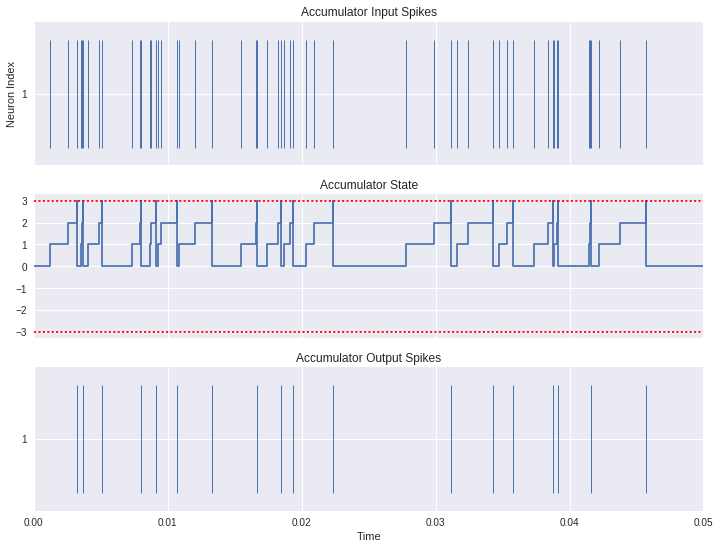

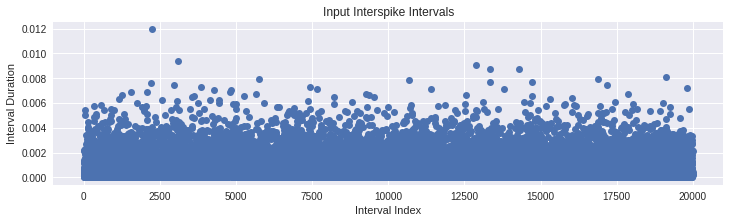

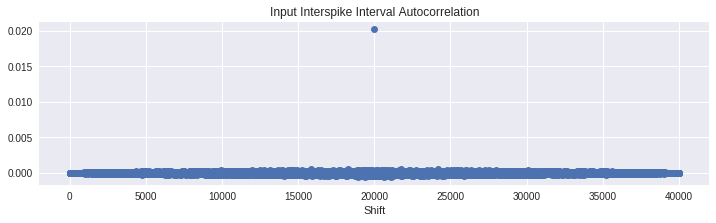

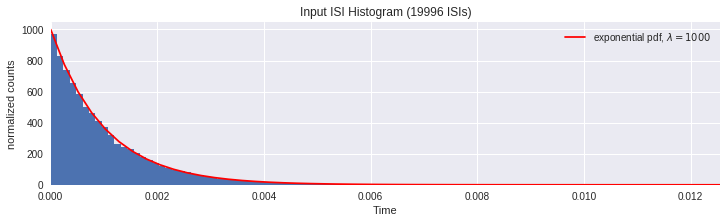

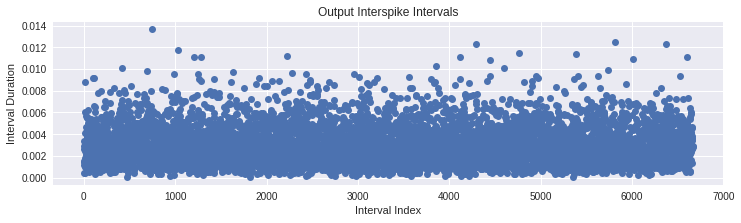

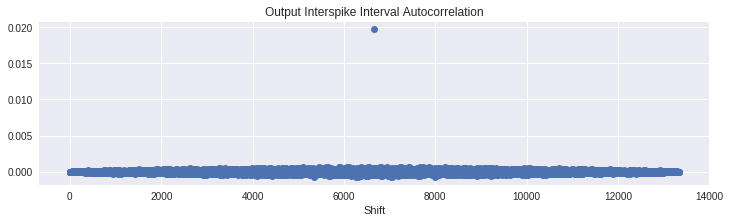

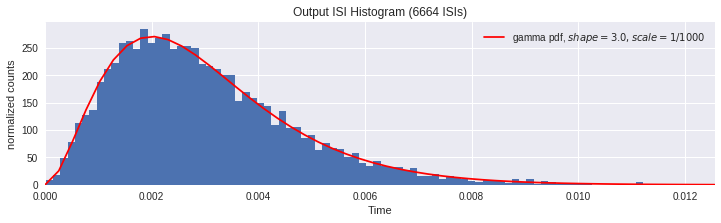

In [29]:
run_poisson_neuron_experiment(weight=1, threshold=3)

As expected, the accumulator output ISIs follow a gamma distribution, which we've already analyzed in another notebook. That's really cool!

We can even get fractional shape parameters by setting the threshold as not a multiple of the weights.

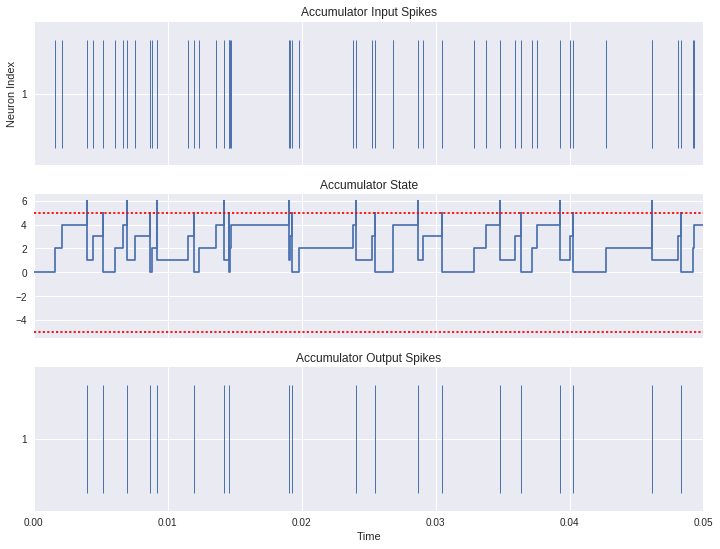

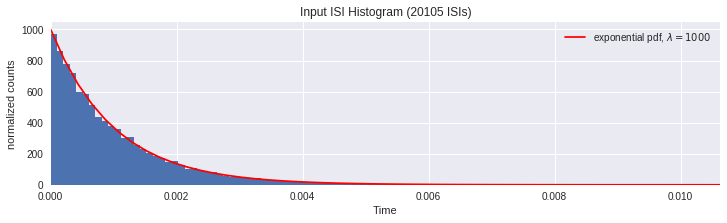

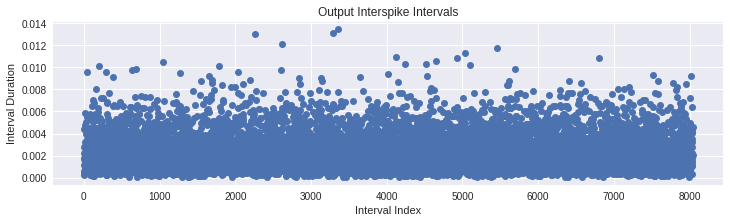

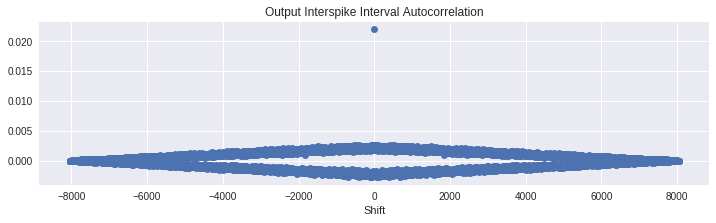

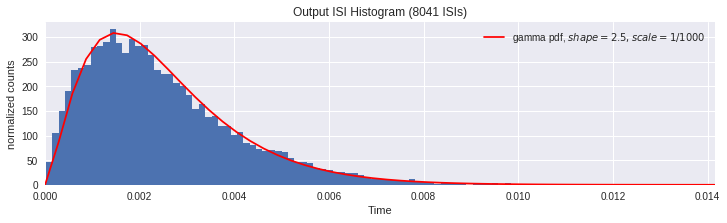

In [32]:
run_poisson_neuron_experiment(weight=2, threshold=5)

But there is more to the story. Note how the autocorrelation of the output ISI now has structure, which indicates that the output ISIs are no longer IID. This makes sense as the accumulator carries over value from one spike to the next because the weight is not a multiple of 


## Many Neurons, Regular Spiking, Random Weights

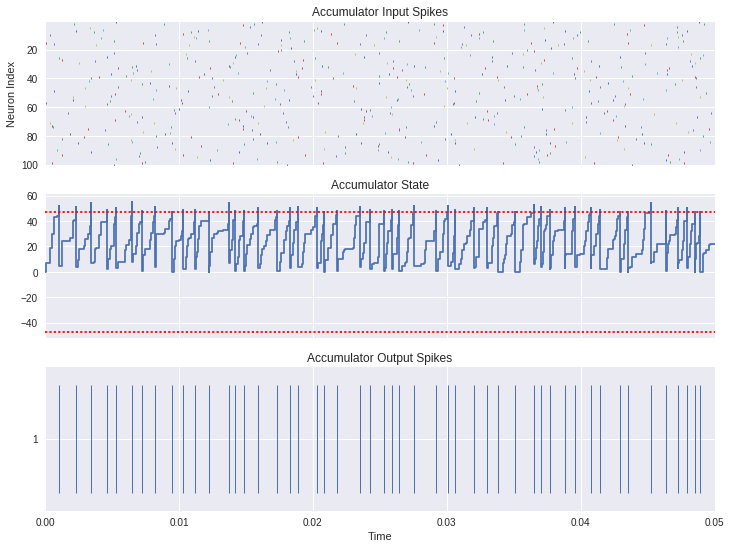

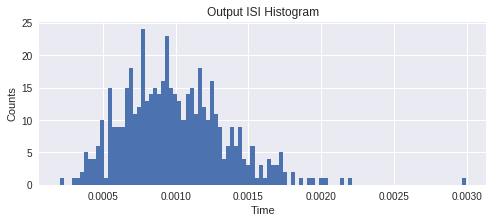

In [5]:
N = 100
input_rates = np.random.uniform(50, 150, size=N)
weights = np.random.randint(0, 11, size=N)
threshold = int(np.sum(input_rates*weights)/1000.)
T=10
spks_in, acc_state, spks_out = run_experiment(
    N=N, input_rates=input_rates, weights=weights, threshold=threshold, T=0.5)
plot_timeseries(spks_in, acc_state, spks_out, tmax=0.05)
plot_isi(spks_out, bins=100)

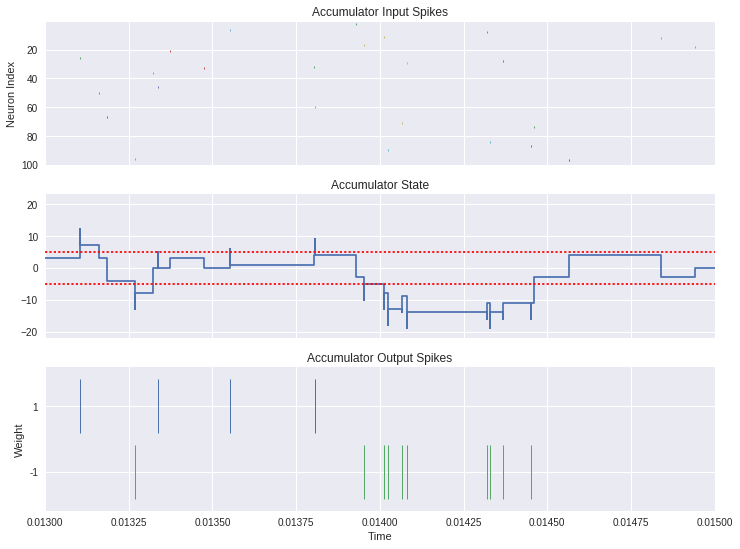

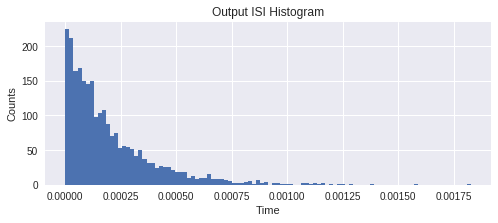

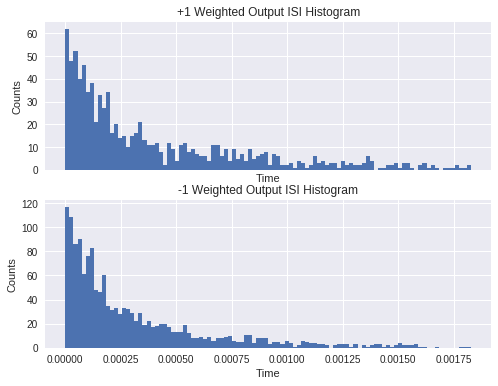

In [6]:
N = 100
np.random.seed(0)
input_rates = np.random.uniform(0, 200, size=N)
weights = np.random.randint(-10, 10, size=N)
threshold = int(np.abs(np.sum(input_rates*weights))/1000.)
T=10
spks_in, acc_state, spks_out = run_experiment(
    N=N, input_rates=input_rates, weights=weights, threshold=threshold, T=0.5)
plot_timeseries(spks_in, acc_state, spks_out, tmin=0.013, tmax=0.015)
plot_isi(spks_out, bins=100)

# Nengo

In [4]:
def threshold_weights(weights):
    """compute the threshold and rounded weights from a given weight distribution
    """
    acc_wmax = np.array([1.] + [127./2**i for i in range(7, 14)])
    acc_unit = np.array([1./64] + [1./2**i for i in range(7, 14)])
    thresholds = np.array([2**i for i in range(6,14)])

    w_max = np.max(np.abs(weights))
    idx = np.argmax(w_max >= acc_wmax)-1
    w_rounded = np.rint(weights/acc_unit[idx]).astype(int)
    threshold = thresholds[idx]   
    return threshold, w_rounded


In [5]:
# build a network
N = 64
net = nengo.Network()
with net:
    stim = nengo.Node(lambda t: np.sin(2*np.pi*t), size_in=0, size_out=1)
    ens = nengo.Ensemble(N, 1)
    node = nengo.Node(lambda t, x: x, size_in=1, size_out=1)
    probe_in = nengo.Probe(stim)
    probe_out = nengo.Probe(node)
    nengo.Connection(stim, ens, synapse=0)
    conn = nengo.Connection(ens, node, function=lambda x: x, transform=1000)

sim = nengo.Simulator(net)

Building finished in 0:00:01.                                                   


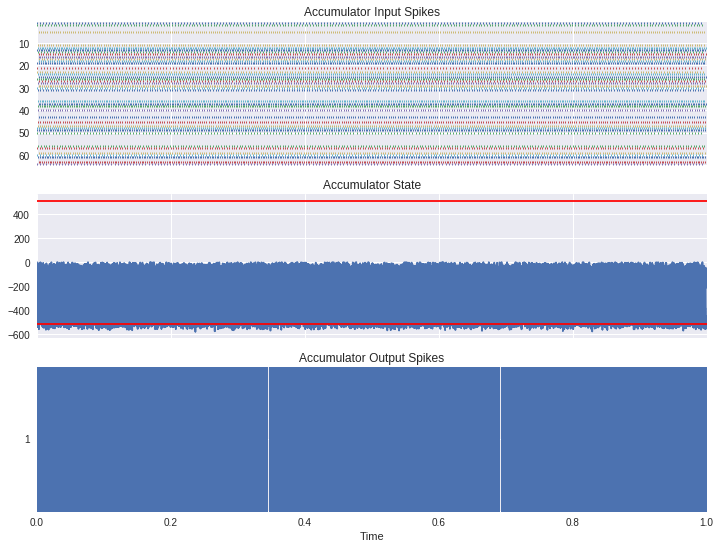

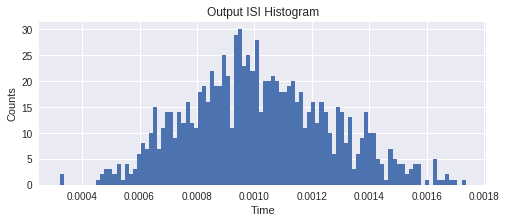

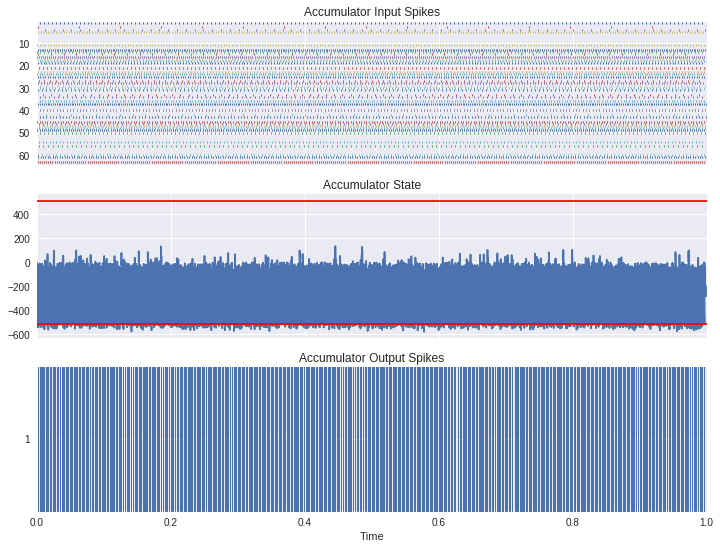

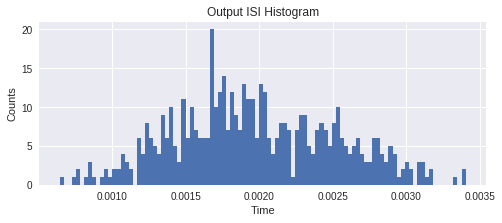

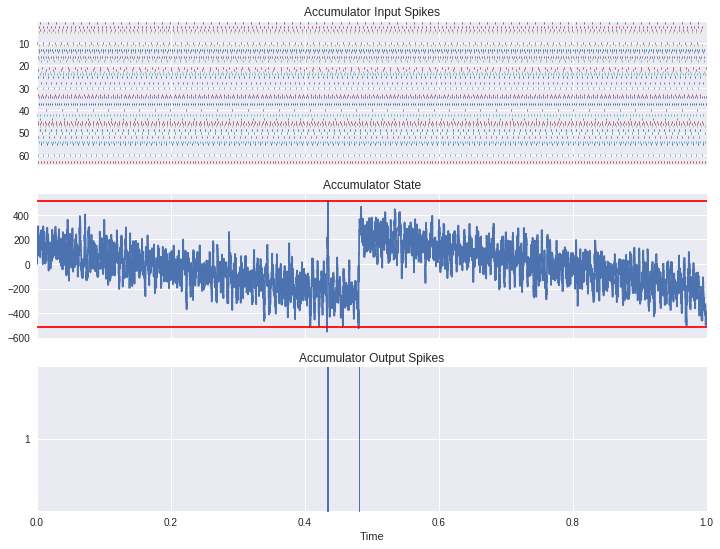

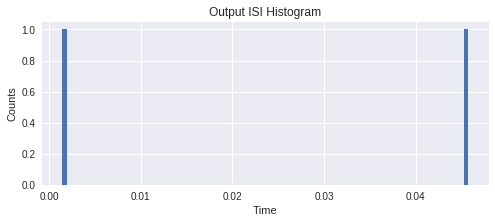

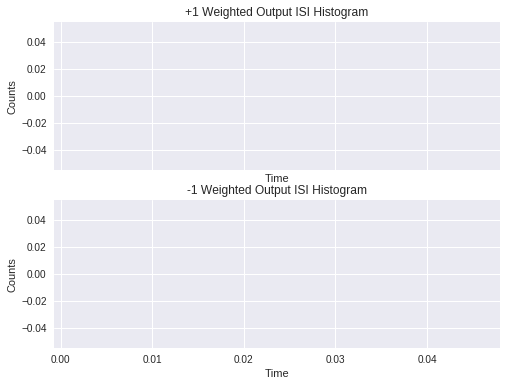

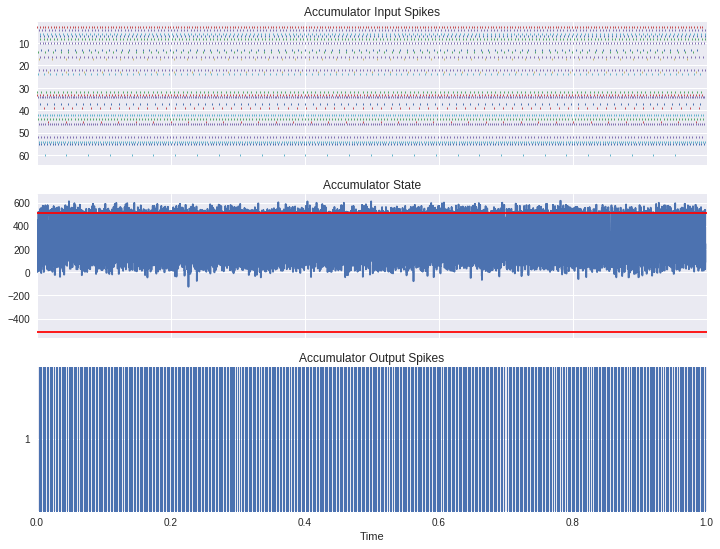

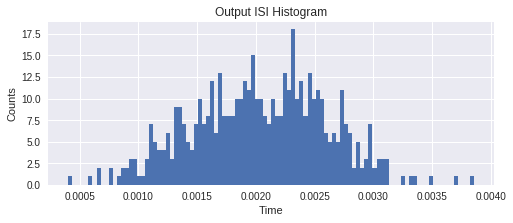

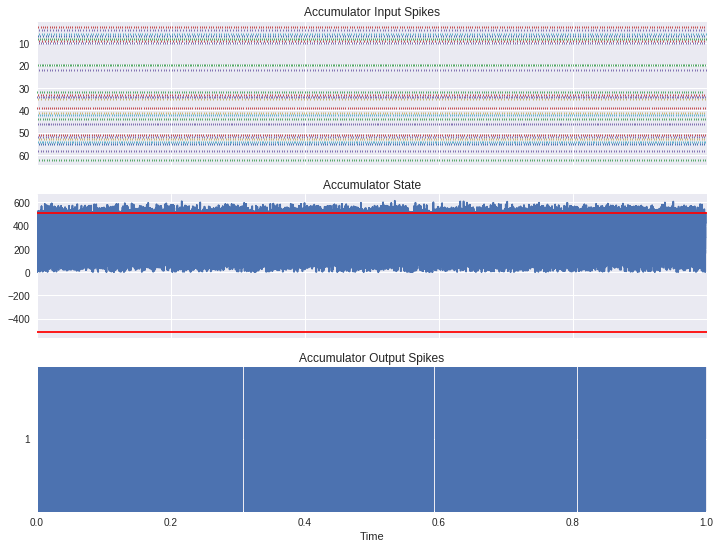

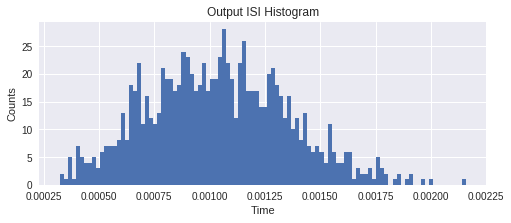

In [6]:
inputs = [-1, -0.5, 0, 0.5, 1]
# inputs = [-1]
for x_in in inputs:
    x, a = tuning_curves(ens, sim, inputs=np.array([x_in]))
    threshold, weights = threshold_weights(sim.data[conn].weights[0])
    spks_in, acc_state, spks_out = run_experiment(
        N=N, input_rates=a, weights=weights, threshold=threshold, T=1.)
    plot_timeseries(spks_in, acc_state, spks_out, tmax=1.)
    plot_isi(spks_out, bins=100)

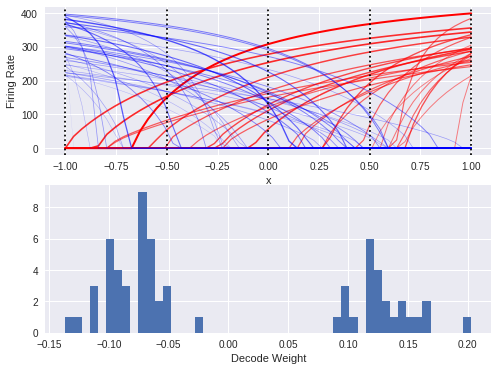

In [34]:
x_test = [-1, -0.5, 0, 0.5, 1]
# print(sim.data[ens].encoders)
fig, axs = plt.subplots(nrows=2, figsize=(8,6))
x, a = tuning_curves(ens, sim)

max_weight = np.max(np.abs(sim.data[conn].weights[0,:]))

for enc, color in zip([1, -1], ['r', 'b']):
    idx = (sim.data[ens].encoders == enc)[:,0]
    lines = axs[0].plot(x, a[:, idx], color)
    line_weights = np.abs(sim.data[conn].weights[0,idx])/max_weight
    for line, line_weight in zip(lines, line_weights):
        line.set_alpha(line_weight)
        line.set_linewidth(line_weight*2)
    
n, bins, patches = axs[1].hist(sim.data[conn].weights[0,:], bins=50)
axs[0].set_xlabel('x')
axs[0].set_ylabel('Firing Rate')
axs[1].set_xlabel('Decode Weight')

for xval in x_test:
    axs[0].axvline(xval, color='k', linestyle=':')

In [8]:
# check the network by running a simulation
sim.run(1)

Simulating finished in 0:00:01.                                                 


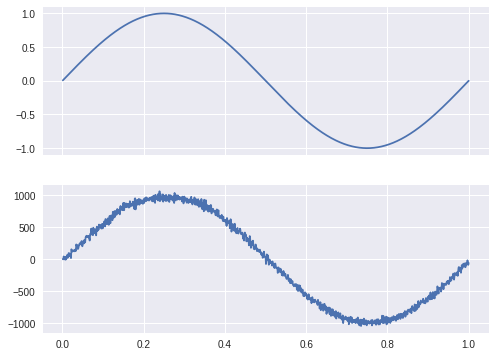

In [9]:
fig, axs = plt.subplots(nrows=2, figsize=(8,6), sharex=True)
# print(sim.data[probe])
# print(sim.trange())
axs[0].plot(sim.trange(), sim.data[probe_in])
axs[1].plot(sim.trange(), sim.data[probe_out])



# Scratchpad

## Renewal Theory

The renewal process generalizes the Poisson process from having exponential inter-event intervals to any distribution inter-event intervals. The key property maintained is that the inter-event intervals are still IID.

Can the regular spiking neuron outputs be treated as a renewal process? Their interspike intervals are deterministic, so could they be cast as degenerate distributions which are independent and identical?

There are definite cases where the output spikes are not iid:
* The input spikes are not derived from a Poisson process
* The threshold is not a multiple of the all of the weights because of the accumulator state carry-over from one spike to the next.

## Palm-Khintchine Theorem

The Palm-Khintchine theorem states that the the super-position of a large number of renewal processes will have Poissonian properties. 
* How large is large?

If we can treat the input neuron spiking as a renewal process, then this theorem seems to apply.

It might be that we can just approximate the accumulator spike rate as a gamma. The threshold will surely not be a multiple of the weights when in a nengo network, but autocorrelation goes down as 